<a href="https://colab.research.google.com/github/preenet/961733-EnergyDataAnalytics/blob/master/PT_Sinthorn_Sentimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sithorn pantip sentimental analysis (re-visit)
# pree.t@cmu.ac.th
# Pree Thiengburanathum, PhD.
# Re-do the Non's work, using different apporaches such as 
# logistic regression, naive bayes of the multinomial and bernoulli varieties with either pure counts or tfidf features
# mount the data from cmu.ac.th gdrive

from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip


  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Created wheel for pythainlp: filename=pythainlp-2.2.0.dev0-cp36-none-any.whl size=12568549 sha256=e8b1c472c82e7cb70842857f13a900d9c78233b2ebb58ac6b4c9d2910660eb6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f5sis7b/wheels/79/4e/1e/26f3198c6712ecfbee92928ed1dde923a078da3d222401cc78
Successfully built pythainlp


In [3]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-1a2088ef-43b8-4a92-b01c-16da3102e033)


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!ls "/content/gdrive/My Drive/Colab Notebooks/PantipSithorn"

correction.txt	pretrained_wiki


In [0]:
import pandas as pd
path = '/content/gdrive/My Drive/Colab Notebooks/PantipSithorn/'

In [0]:
df = pd.read_csv(path+'correction.txt')

In [8]:
df.describe()

,result
count,3789.000000
mean,0.377408
std,0.913975
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
# find meta and basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3789 entries, 0 to 3788
Data columns (total 2 columns):
result        3789 non-null int64
correction    3759 non-null object
dtypes: int64(1), object(1)
memory usage: 59.3+ KB


In [10]:
df.head(3)

,result,correction
0,-1,"ตำรา,คุณปู่,ไม่เชื่อ,ต้องตาม,ดู"
1,-1,"หรั่ง,เล่น,งี้,รอบ,อัด,ตอน,ATO"
2,1,"ปู่,ชอบ,เล่น,รถไฟ,เหาะ,ลาก,ขึ้นไป,รอ,เม่า,นั่ง..."


In [11]:
df.tail(3)

,result,correction
3786,1,"แบบนี้,👍🏻👍🏻"
3787,0,"จ่าย,อะ,ไหม"
3788,-1,"ขอรับ,รอ,tracking,ขอรับ,555"


In [12]:
# check for any missing vlue
df.isnull().sum()

result         0
correction    30
dtype: int64

In [0]:
# drop nan vaule

df.dropna(subset=['correction'],inplace=True)

In [14]:
df['result'].value_counts()

 1    2552
-1    1126
 0      81
Name: result, dtype: int64

In [0]:
# drop the netreul class
df = df.drop(df[df['result'] == 0].index)

In [16]:
# we now have a simple two class binary problem (ratio 1:2)
df['result'].value_counts()

 1    2552
-1    1126
Name: result, dtype: int64

In [17]:
from pythainlp.word_vector import *
from pythainlp import word_vector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
from sklearn.model_selection import StratifiedShuffleSplit


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [18]:
X, y = [], []
r, c = df.shape
for text in range (r):
  x = df['correction'].str.split(',')
  X = x.replace(',', '')
  y = df['result']
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))
n = r;

total examples 3678


In [0]:
# Pipe line for all models start with the classics - logistic regression, naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features

logistic = LogisticRegression(max_iter=10000, tol=0.1)

logis = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("logistic",  logistic)])
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="rbf"))])

In [0]:

all_models = [
    ("logis", logis),
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
]

In [0]:
unsorted_scores = [(name, cross_val_score(model, X, y, cv = 5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

In [22]:
print ('Classiication Accuracy for the pantip sentiment_sinthron1A dataset')
print (['Binary class problem, 5 folds CV'])
print (tabulate(scores, floatfmt=".4f", headers=("model", 'acc.')))

Classiication Accuracy for the pantip sentiment_sinthron1A dataset
['Binary class problem, 5 folds CV']
model            acc.
-------------  ------
svc_tfidf      0.7028
mult_nb_tfidf  0.6990
logis          0.6963
bern_nb        0.6938
bern_nb_tfidf  0.6938
mult_nb        0.6933
svc            0.6765


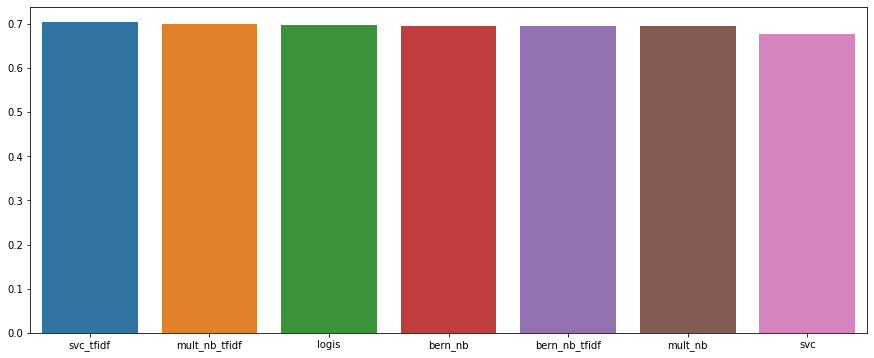

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

In [24]:
# try word 2 vec
!pip install gensim
from gensim.models import Word2Vec


In [25]:


from pythainlp.word_vector import * 
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


In [26]:


model_th_wiki = get_model()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:

all_words = set(w for words in X for w in words)


In [0]:
thwiki = {}
for w in range(len(all_words)):
  if (list(all_words)[w] in model_th_wiki.index2word):
    nums = model_th_wiki.word_vec(list(all_words)[w])
    thwiki[list(all_words)[w]] = nums
  else:
    pass

In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(thwiki))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(thwiki))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                     ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                      ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_thwiki = Pipeline([("thwiki vectorizer", MeanEmbeddingVectorizer(thwiki)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_thwiki_tfidf = Pipeline([("thwiki vectorizer", TfidfEmbeddingVectorizer(thwiki)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])


In [0]:

all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("extra trees-w2v", etree_w2v),
    ("extra trees-w2v_tfidf", etree_w2v_tfidf),
    ("extra trees-th-wiki", etree_thwiki),
    ("extra trees-th-wiki_tfidf", etree_thwiki_tfidf),

]



In [32]:

from collections import Counter, defaultdict
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt=".4f", headers=("model", 'acc.')))

model            acc.
-------------  ------
svc_tfidf      0.7028
mult_nb_tfidf  0.6990
bern_nb        0.6938
bern_nb_tfidf  0.6938
mult_nb        0.6933
th-wiki_tfidf  0.6925
th-wiki        0.6917
w2v_tfidf      0.6767
svc            0.6765
w2v            0.6705


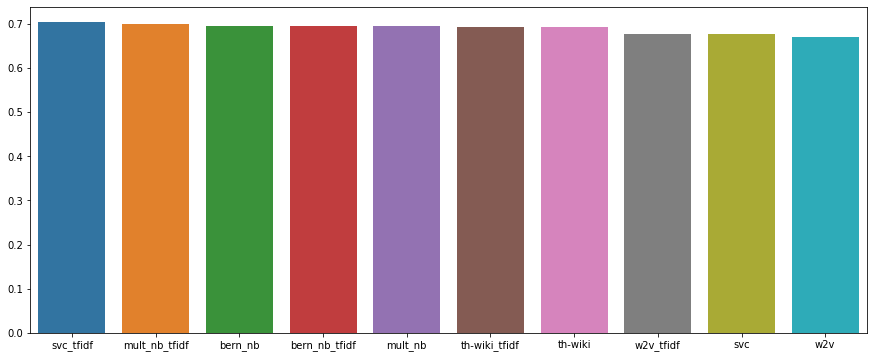

In [33]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

In [0]:

def benchmark(model, X, y, t):
    scores = []
    sss=  StratifiedShuffleSplit(n_splits=5, train_size = t, test_size=  int(t*0.20))
    for train_index, test_index in sss.split(X, y):
        #print (len(train_index), ', ' , len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [0]:
train_sizes = [10, 60, 260, 640, 1260, 2200, 3000]
table = []
for name, model in all_models:
    for t in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, t), 
                      'train_size': t})
df1 = pd.DataFrame(table)

[Text(0.5, 1.0, 'SinthornA2 benchmark')]

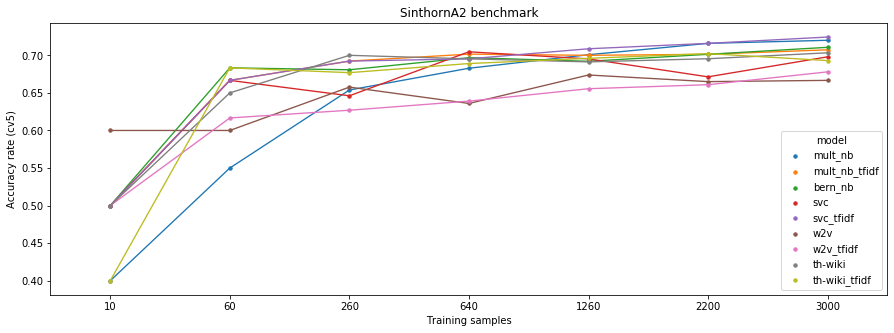

In [36]:

plt.figure(figsize=(15, 5))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df1[df1.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "extra trees-w2v","extra trees-w2v_tfidf", 
                                                         "mult_nb_tfidf", "bern_nb", "extra trees-th-wiki", "extra trees-th-wiki_tfidf", 
                                                         "svc", "svc_tfidf"
                                                        ])], scale =0.5)
  
sns.set_context("notebook", font_scale=1.0)
fig.set(ylabel="Accuracy rate (cv5)")
fig.set(xlabel="Training samples")
fig.set(title="SinthornA2 benchmark")



In [37]:
!pip install keras



In [50]:
df_col_len = int(df['correction'].str.encode(encoding='utf-8').str.len().max())
df_col_len


array([-1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1,
        0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1, -1,  0,
        0,  0,  0,  0, -1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1, -1,  0,
        0, -1,  0,  0, -1,  0,  0, -1,  0, -1,  0,  0, -1,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0, -1,
       -1, -1,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,
       -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0, -1,  0, -1, -1,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
        0, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  0, -1,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0,
        0, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,
        0,  0, -1,  0,  0

In [0]:
 def Build_Model_DNN_Text(shape):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    model.add(Dense(512,input_dim=shape, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print (model.summary() )
    return model


In [0]:
def TFIDF(X_train, X_test, MAX_NB_WORDS=75000):
  
    vectorizer_x = TfidfVectorizer(analyzer=lambda x: x)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    print("tf-idf with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)

In [72]:

sss=  StratifiedShuffleSplit(n_splits=1, train_size = 2800, test_size=  int(t*0.25))
# normalize to range [0,1]
y = np.where(y==-1, 0 , y)
for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(y)
X_train_tfidf , X_test_tfidf = TFIDF(X_train,X_test)
#y_train =to_categorical(y_train)
#y_test =to_categorical(y_test)

[0 0 1 ... 0 1 0]
tf-idf with 8805 features


In [73]:
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding

from keras import Sequential
from sklearn import metrics



model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1])

model_DNN.fit(X_train_tfidf, y_train,
                              validation_data=(X_test_tfidf, y_test),
                              epochs=100,
                              batch_size=len(X_train),
                              )
y_pred = model_DNN.predict(X_test_tfidf)
print(metrics.classification_report(y_test, np.argmax(y_pred, axis=1)))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               4508672   
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 4,681,217
Trainable params: 4,681,217
Non-trainable params: 0
_________________________________________________________________
None
Train on 2800 samples, validate on 750 samples
Epoch 1/100
2800/2800 [==============================] - 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


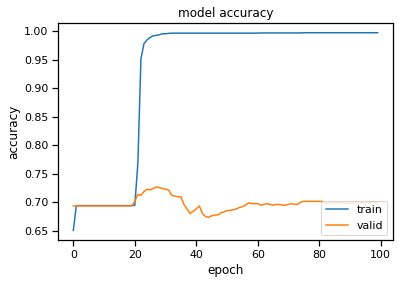

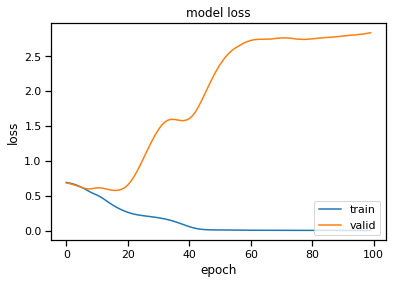

In [74]:
print(model_DNN.history.history.keys())
# summarize history for accuracy
plt.plot(model_DNN.history.history['acc'])
plt.plot(model_DNN.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(model_DNN.history.history['loss'])
plt.plot(model_DNN.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

In [57]:
y_train

array([-1, -1,  1, ...,  1,  1,  1])